**PhysioNet** (the hospital sensors: EDA, HR, TEMP, ACC)

**What you did**
Read raw files (often they had no friendly timestamps).


**Rebuilt timestamps:** when files did not include time, you created a clock starting from a chosen time (e.g., 9:00 AM), then ticked forward at the right speed.


**Cleaned EDA:** removed slow drifts and smoothed with a gentle filter so the sweat signal looks sensible (no spiky garbage).


**Built ACC columns**: separated acceleration into x, y, z and added ACC_mag (a single number that says “how much movement”).


Resampled everything to a common tempo (we used 4 Hz — that means 4 measurements each second).


Joined all signals together into one tidy table with the same timestamps.


**Windowed:** cut into small clips (e.g., windows of 60 seconds with 30 seconds overlap, or shorter windows for quick checks).


Saved each subject as data_processed/physio_subject_xx.parquet and windows as data_processed/physio_subject_xx_windows.npz.


**Why**
Sensors recorded at different speeds and formats. Making them all play at 4 beats per second means we can compare them side-by-side easily. Windows make little training examples for the computer.


**What it looks like after**
For each subject: a clean Parquet file with columns like EDA, HR, TEMP, ACC_x, ACC_y, ACC_z, ACC_mag, and label (if available).


Arrays of windows (.npz) with shapes like (many_windows, window_length_in_timesteps, n_features).

In [ ]:
BASE = "/content/drive/MyDrive/stress-project"
FS_OUT = 4      # Target: 4 Hz for all signals
WIN_SEC = 60    # Each window is 60 seconds long
STRIDE_SEC = 30 # Overlap is 30 seconds


Load and Align PhysioNet Signals

In [ ]:
!pip install pandas==2.2.3 --quiet
!pip install wfdb==4.3.0


In [ ]:
!pip install matplotlib-venn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/stress-project')


In [ ]:
import os

base = "/content/drive/MyDrive/stress-project/data_raw/physionet_exam/Subject_01"
print(os.path.exists(base))          # check if folder exists
print(os.listdir(os.path.dirname(base)))  # list parent folder


True
['Subject_01', 'Subject_02', 'Subject_03', 'Subject_04', 'Subject_05', 'StudentGrades.txt']


In [ ]:
import pandas as pd

# Use 'base' instead of 'sd'
eda_cols  = pd.read_csv(f"{base}/EDA.csv", header=None).columns.tolist()
hr_cols   = pd.read_csv(f"{base}/HR.csv", header=None).columns.tolist()
acc_cols  = pd.read_csv(f"{base}/ACC.csv", header=None).columns.tolist()
temp_cols = pd.read_csv(f"{base}/TEMP.csv", header=None).columns.tolist()

print("EDA columns:", eda_cols)
print("HR columns:", hr_cols)
print("ACC columns:", acc_cols)
print("TEMP columns:", temp_cols)


EDA columns: [0]
HR columns: [0]
ACC columns: [0, 1, 2]
TEMP columns: [0]


In [ ]:
eda = pd.read_csv(f"{base}/EDA.csv", header=None, sep=",")
print(eda.head())
print(eda.shape)


              0
0  1.544027e+09
1  4.000000e+00
2  0.000000e+00
3  5.125000e-03
4  2.050100e-02
(93584, 1)


In [ ]:
import pandas as pd

eda = pd.read_csv(
    "/content/drive/MyDrive/stress-project/data_raw/physionet_exam/Subject_01/EDA.csv",
    header=None,          # no headers in file
    skipinitialspace=True,# remove extra spaces
    decimal='.'           # ensure dot is decimal separator
)

eda.columns = ['EDA']
print(eda.head(10))


            EDA
0  1.544027e+09
1  4.000000e+00
2  0.000000e+00
3  5.125000e-03
4  2.050100e-02
5  2.178300e-02
6  2.306400e-02
7  2.434500e-02
8  2.306400e-02
9  2.178300e-02


In [ ]:
import pandas as pd
import numpy as np

# Path to your CSV
file_path = "/content/drive/MyDrive/stress-project/data_raw/physionet_exam/Subject_01/EDA.csv"

# Read all values (skip first row which is timestamp)
raw = pd.read_csv(file_path, header=None, skiprows=1)
eda_values = pd.to_numeric(raw[0], errors='coerce')

# Fill any NaNs just in case
eda_values = eda_values.interpolate().ffill().bfill()

# Generate timestamps starting at 9 AM, assuming 4 Hz sampling
start_time = pd.to_datetime("2018-12-05 09:00:00")
timestamps = start_time + pd.to_timedelta(np.arange(len(eda_values))/4, unit='s')

# Build DataFrame
eda_df = pd.DataFrame({'EDA': eda_values.values}, index=timestamps)
eda_df.index.name = 'timestamp'

print(eda_df.head())


                              EDA
timestamp                        
2018-12-05 09:00:00.000  4.000000
2018-12-05 09:00:00.250  0.000000
2018-12-05 09:00:00.500  0.005125
2018-12-05 09:00:00.750  0.020501
2018-12-05 09:00:01.000  0.021783


Convert values to numbers and fill missing values.

Create timestamps assuming 4 Hz sampling.

Build a time-indexed DataFrame.

In [ ]:
import pandas as pd
import numpy as np
import os
from scipy.signal import detrend, savgol_filter

BASE = "/content/drive/MyDrive/stress-project/data_raw/physionet_exam"

# -----------------------------
# Helper functions
# -----------------------------
def clean_series(series):
    s = pd.to_numeric(series, errors='coerce')
    s = s.replace([np.inf, -np.inf], np.nan)
    s = s.interpolate().ffill().bfill()
    return s

def generate_timestamps(n_samples, start_time="2018-12-05 09:00:00", sampling_rate=4):
    start = pd.to_datetime(start_time)
    return start + pd.to_timedelta(np.arange(n_samples)/sampling_rate, unit='s')

def load_signal(file_path, col_name, sampling_rate=4):
    raw = pd.read_csv(file_path, header=None, skiprows=1)
    values = clean_series(raw[0])
    timestamps = generate_timestamps(len(values), sampling_rate=sampling_rate)
    df = pd.DataFrame({col_name: values.values}, index=timestamps)
    df.index.name = 'timestamp'
    return df

def load_acc(file_path, sampling_rate=32):
    raw = pd.read_csv(file_path, header=None, skiprows=1)
    arr = clean_series(raw[0]).values
    n_samples = len(arr) // 3
    arr = arr[:n_samples*3].reshape(-1,3)
    df = pd.DataFrame(arr, columns=['x','y','z'])
    df['acc_mag'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    timestamps = generate_timestamps(n_samples, sampling_rate=sampling_rate)
    df.index = timestamps
    df.index.name = 'timestamp'
    return df

def preprocess_eda(eda_df, window=41, polyorder=3):
    eda_array = eda_df.iloc[:,0].values
    eda_array = detrend(eda_array)
    eda_array = savgol_filter(eda_array, window, polyorder)
    eda_df.iloc[:,0] = eda_array
    return eda_df

def resample_signal(df, freq='250ms'):
    """Resample DataFrame to fixed frequency using median interpolation"""
    return df.resample(freq).median().interpolate()

def load_subject(subject_folder, rates={'eda':4,'hr':1,'temp':1,'acc':32}):
    path = os.path.join(BASE, subject_folder)
    data = {}
    # Load raw signals
    data['EDA']  = preprocess_eda(load_signal(f"{path}/EDA.csv", 'EDA', rates['eda']))
    data['HR']   = load_signal(f"{path}/HR.csv", 'HR', rates['hr'])
    data['TEMP'] = load_signal(f"{path}/TEMP.csv", 'TEMP', rates['temp'])
    data['ACC']  = load_acc(f"{path}/ACC.csv", rates['acc'])
    # Resample all signals to 250 ms
    data['EDA']  = resample_signal(data['EDA'])
    data['HR']   = resample_signal(data['HR'])
    data['TEMP'] = resample_signal(data['TEMP'])
    data['ACC']  = resample_signal(data['ACC'])
    return data

# -----------------------------
# Load all subjects
# -----------------------------
subjects = [d for d in os.listdir(BASE) if d.startswith("Subject_")]
all_data = {subj: load_subject(subj) for subj in subjects}

# -----------------------------
# Quick check
# -----------------------------
print("Subjects loaded:", list(all_data.keys()))
print("EDA sample for Subject_01:\n", all_data['Subject_01']['EDA'].head())
print("\nHR sample for Subject_01:\n", all_data['Subject_01']['HR'].head())
print("\nTEMP sample for Subject_01:\n", all_data['Subject_01']['TEMP'].head())
print("\nACC sample for Subject_01:\n", all_data['Subject_01']['ACC'].head())


Subjects loaded: ['Subject_01', 'Subject_02', 'Subject_03', 'Subject_04', 'Subject_05']
EDA sample for Subject_01:
                               EDA
timestamp                        
2018-12-05 09:00:00.000  1.118878
2018-12-05 09:00:00.250  0.891865
2018-12-05 09:00:00.500  0.687414
2018-12-05 09:00:00.750  0.504504
2018-12-05 09:00:01.000  0.342116

HR sample for Subject_01:
                              HR
timestamp                      
2018-12-05 09:00:00.000    1.00
2018-12-05 09:00:00.250   29.75
2018-12-05 09:00:00.500   58.50
2018-12-05 09:00:00.750   87.25
2018-12-05 09:00:01.000  116.00

TEMP sample for Subject_01:
                             TEMP
timestamp                       
2018-12-05 09:00:00.000   4.0000
2018-12-05 09:00:00.250   8.4725
2018-12-05 09:00:00.500  12.9450
2018-12-05 09:00:00.750  17.4175
2018-12-05 09:00:01.000  21.8900

ACC sample for Subject_01:
                            x    y    z   acc_mag
timestamp                                       
2018-1

clean_series → remove NaNs & infinities.

generate_timestamps → create timestamps.

load_signal → load HR, TEMP, EDA.

load_acc → load ACC (x,y,z) + compute magnitude.

preprocess_eda → detrend & smooth EDA using Savitzky-Golay filter.

resample_signal → make all signals same sampling rate (250ms).

load_subject → load all signals for a subject and resample.

In [ ]:
all_data['Subject_01']['EDA']
all_data['Subject_01']['HR']
all_data['Subject_01']['TEMP']
all_data['Subject_01']['ACC']


,x,y,z,acc_mag
timestamp,,,,
2018-12-05 09:00:00.000,-3.0,-3.0,-3.0,5.196152
2018-12-05 09:00:00.250,-3.0,-3.0,-3.0,5.196152
2018-12-05 09:00:00.500,-3.0,-3.0,-3.0,5.196152
2018-12-05 09:00:00.750,-3.0,-3.0,-3.0,5.196152
2018-12-05 09:00:01.000,-3.0,-3.0,-3.0,5.196152
...,...,...,...,...
2018-12-05 11:09:57.750,-11.0,-11.0,-11.0,19.052559
2018-12-05 11:09:58.000,-12.0,-12.0,-12.5,21.081084
2018-12-05 11:09:58.250,-37.5,-35.0,-37.5,65.292610


Automatically find all subjects’ folders.

Load and preprocess EDA, HR, TEMP, ACC for each subject.

In [ ]:
import os

processed_dir = os.path.join(BASE, "data_processed")
os.makedirs(processed_dir, exist_ok=True)

for subject in subjects:
    eda  = all_data[subject]['EDA']
    hr   = all_data[subject]['HR']
    temp = all_data[subject]['TEMP']
    acc  = all_data[subject]['ACC']

    # Merge all signals by timestamp
    df = eda.join([hr, temp, acc], how='outer')
    df = df.interpolate().ffill().bfill()  # Fill any remaining NaNs

    # Save to Parquet
    out_file = os.path.join(processed_dir, f"physio_{subject.lower()}.parquet")
    df.to_parquet(out_file)

    print(f"Saved processed data for {subject} -> {out_file}")


Saved processed data for Subject_01 -> /content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed/physio_subject_01.parquet
Saved processed data for Subject_02 -> /content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed/physio_subject_02.parquet
Saved processed data for Subject_03 -> /content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed/physio_subject_03.parquet
Saved processed data for Subject_04 -> /content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed/physio_subject_04.parquet
Saved processed data for Subject_05 -> /content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed/physio_subject_05.parquet


Join all signals by timestamp.

Fill missing values.

Save to Parquet → clean, ready-to-use dataset.

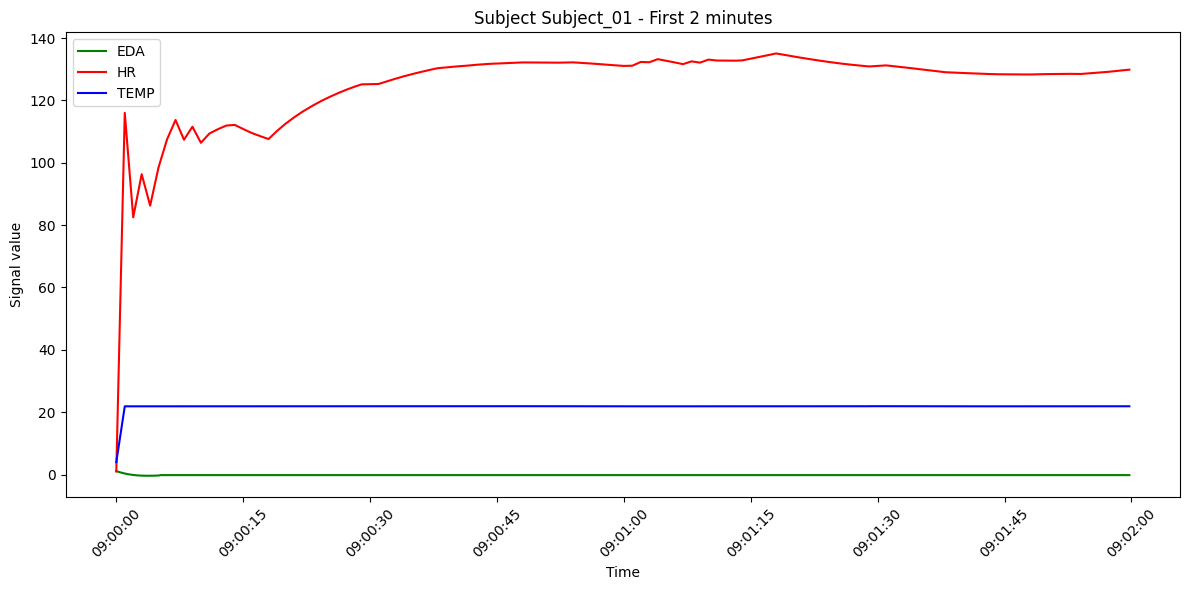

In [ ]:
import matplotlib.pyplot as plt

subject = 'Subject_01'

# Load merged Parquet
file_path = os.path.join(BASE, "data_processed", f"physio_{subject.lower()}.parquet")
df = pd.read_parquet(file_path)

# Take first ~2 minutes of data (250 ms sampling -> 480 rows)
df_window = df.iloc[:480]

# Plot EDA, HR, TEMP
plt.figure(figsize=(12,6))
plt.plot(df_window.index, df_window['EDA'], label='EDA', color='green')
plt.plot(df_window.index, df_window['HR'], label='HR', color='red')
plt.plot(df_window.index, df_window['TEMP'], label='TEMP', color='blue')
plt.xlabel('Time')
plt.ylabel('Signal value')
plt.title(f'Subject {subject} - First 2 minutes')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Visual check

In [ ]:
import numpy as np

def make_windows(df, cols, win_sec, stride_sec, fs_out):
    """
    Convert time series DataFrame into sliding windows.

    Parameters:
        df         : pandas DataFrame, indexed by timestamp
        cols       : list of columns to include in windows
        win_sec    : window length in seconds
        stride_sec : stride length in seconds
        fs_out     : sampling rate (Hz) of df

    Returns:
        X     : numpy array (n_windows, n_timesteps, n_channels)
        y     : numpy array (n_windows,) placeholder labels (zeros)
        spans : list of (start_time, end_time) for each window
    """
    data = df[cols].values
    n_samples_per_win = int(win_sec * fs_out)
    stride_samples = int(stride_sec * fs_out)
    n_samples, n_channels = data.shape

    X = []
    spans = []

    for start in range(0, n_samples - n_samples_per_win + 1, stride_samples):
        end = start + n_samples_per_win
        X.append(data[start:end, :])
        spans.append((df.index[start], df.index[end-1]))

    X = np.array(X)
    y = np.zeros(X.shape[0])  # Placeholder labels
    return X, y, spans


In [ ]:
processed_dir = os.path.join(BASE, "data_processed")

WIN_SEC = 10
STRIDE_SEC = 5
FS_OUT = 4  # output sampling rate in Hz (matches EDA resampling)

for subject in subjects:
    # Load merged Parquet
    file_path = os.path.join(processed_dir, f"physio_{subject.lower()}.parquet")
    df = pd.read_parquet(file_path)

    # Columns to include in windows
    cols_for_windows = [c for c in ['EDA','HR','TEMP','x','y','z','acc_mag'] if c in df.columns]

    # Generate windows
    X, y, spans = make_windows(df, cols_for_windows, WIN_SEC, STRIDE_SEC, FS_OUT)

    # Save to npz
    out_file = os.path.join(processed_dir, f"physio_{subject.lower()}_windows.npz")
    np.savez(out_file, X=X, y=y, spans=spans)

    print(f"Saved windows for {subject} -> {out_file}")


Saved windows for Subject_01 -> /content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed/physio_subject_01_windows.npz
Saved windows for Subject_02 -> /content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed/physio_subject_02_windows.npz
Saved windows for Subject_03 -> /content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed/physio_subject_03_windows.npz
Saved windows for Subject_04 -> /content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed/physio_subject_04_windows.npz
Saved windows for Subject_05 -> /content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed/physio_subject_05_windows.npz


Cut time-series into windows for modeling.

Each window = X (features) + y (labels placeholder) + spans (start/end times).

Generate sliding windows (10 sec long, stride 5 sec).

Save as .npz → ready for ML

In [ ]:
import numpy as np
import os

subject = 'Subject_01'
file_path = os.path.join(BASE, "data_processed", f"physio_{subject.lower()}_windows.npz")

# Load the saved windows, allow pickled objects
data = np.load(file_path, allow_pickle=True)

X = data['X']      # shape: (n_windows, n_timesteps, n_channels)
y = data['y']      # labels per window
spans = data['spans']  # start/end timestamps per window

print(f"Subject: {subject}")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("spans shape:", spans.shape)
print("\nSample first window (X[0]):")
print(X[0])
print("\nSample first label (y[0]):", y[0])
print("\nSample first time span:", spans[0])


Subject: Subject_01
X shape: (18715, 40, 7)
y shape: (18715,)
spans shape: (18715, 2)

Sample first window (X[0]):
[[ 1.11887750e+00  1.00000000e+00  4.00000000e+00 -3.00000000e+00
  -3.00000000e+00 -3.00000000e+00  5.19615242e+00]
 [ 8.91865312e-01  2.97500000e+01  8.47250000e+00 -3.00000000e+00
  -3.00000000e+00 -3.00000000e+00  5.19615242e+00]
 [ 6.87413900e-01  5.85000000e+01  1.29450000e+01 -3.00000000e+00
  -3.00000000e+00 -3.00000000e+00  5.19615242e+00]
 [ 5.04503845e-01  8.72500000e+01  1.74175000e+01 -3.00000000e+00
  -3.00000000e+00 -3.00000000e+00  5.19615242e+00]
 [ 3.42115722e-01  1.16000000e+02  2.18900000e+01 -3.00000000e+00
  -3.00000000e+00 -3.00000000e+00  5.19615242e+00]
 [ 1.99230109e-01  1.07625000e+02  2.18900000e+01 -3.00000000e+00
  -3.00000000e+00 -3.00000000e+00  5.19615242e+00]
 [ 7.48275795e-02  9.92500000e+01  2.18900000e+01 -3.00000000e+00
  -3.00000000e+00 -3.00000000e+00  5.19615242e+00]
 [-3.21112892e-02  9.08750000e+01  2.18900000e+01 -3.00000000e+00


In [ ]:
Check shapes: (n_windows, n_timesteps, n_channels)